# WikiText-2 Transformer Scaling Experiments (PyTorch)

This notebook trains decoder-only Transformers on WikiText-2 and compares
performance as a function of several independent variables:

1. **Depth** -- varying number of transformer blocks (fixed width)
2. **Width** -- varying d_model (fixed depth)
3. **Batch Size** -- varying training batch size
4. **Dropout** -- varying dropout rate
5. **L2 Regularization** -- varying weight decay
6. **L1 Regularization** -- varying L1 penalty strength
7. **Elastic Net (Ratio)** -- varying L1/L2 ratio at fixed total strength
8. **Elastic Net (Strength)** -- varying total strength at fixed ratio

For each experiment we produce loss curve plots comparing the settings.

Everything is self-contained -- no external project files needed.

## 1. Setup and Dependencies


In [1]:
# Install dependencies
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q matplotlib numpy datasets

print('Dependencies installed')

Dependencies installed


In [2]:
# Optional: mount Google Drive for persistent outputs
MOUNT_DRIVE = False

if MOUNT_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    print('Google Drive mounted')
else:
    print('Drive mount skipped (set MOUNT_DRIVE=True to enable)')


Drive mount skipped (set MOUNT_DRIVE=True to enable)


## 2. Download WikiText-2

In [3]:
from datasets import load_dataset

wikitext = load_dataset('wikitext', 'wikitext-2-raw-v1')

print('WikiText-2 loaded from HuggingFace')
print(f'  Train: {len(wikitext["train"])} lines')
print(f'  Valid: {len(wikitext["validation"])} lines')
print(f'  Test:  {len(wikitext["test"])} lines')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

WikiText-2 loaded from HuggingFace
  Train: 36718 lines
  Valid: 3760 lines
  Test:  4358 lines


In [4]:
import torch

print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')


PyTorch version: 2.10.0+cu128
CUDA available: True
GPU: Tesla T4


## 3. Imports and Configuration


In [6]:
import os
import json
import time
import math
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


# ---------------------------------------------------------------------------
# Decoder-only Transformer (GPT-style) -- inlined for self-contained notebook
# ---------------------------------------------------------------------------

def create_positional_encoding(max_len, d_model):
    """
    Positional encoding as used in the paper that introduced the concept
    of the transformer:
    A. Vaswani et al., "Attention is all you need," in Advances in
    Neural Information Processing Systems, 2017, pp. 5998–6008.
    """
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(
        torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
    )
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe


def create_causal_mask(seq_len, device):
    """
    Create a lower-triangular (causal) attention mask so that position t
    can only attend to positions <= t. This prevents each token's
    prediction from accessing future tokens and enforces autoregressive,
    next-token-style training/generation.
    """
    mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask


class MultiHeadAttention(nn.Module):
    """
    The self-attention sublayer.
    Note: We haven't covered multi-head attention yet.
    """
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        Apply multi-head self-attention to the input sequence.

        Args:
            x (torch.Tensor): Input tensor of shape (B, S, D) where
                B is batch size, S is sequence length, and D is the
                model dimension.
            mask (torch.Tensor, optional): Additive attention mask of shape
                (S, S) or (B, S, S), where masked positions should contain a
                large negative value (e.g., -1e9) so they are ignored after
                softmax (useful for causal or padding masks).

        Returns:
            torch.Tensor: Output tensor of shape (B, S, D) after computing
                scaled dot-product attention over multiple heads and
                projecting back to the model dimension.
        """
        B, S, D = x.size()
        Q = self.W_q(x).view(B, S, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(B, S, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(B, S, self.n_heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores + mask.unsqueeze(0).unsqueeze(0)
        attn = self.dropout(F.softmax(scores, dim=-1))
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(B, S, D)
        return self.W_o(out)


class FeedForward(nn.Module):
    """
    The feed forward sublayer
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))


class DecoderLayer(nn.Module):
    """
    This represents the entire forward pass of a transformer. Given an
    embedding, it will pass the embedding through the self-attention and
    feed-forward sublayers.
    """
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.norm1(x + self.dropout1(self.self_attn(x, mask)))
        x = self.norm2(x + self.dropout2(self.feed_forward(x)))
        return x


class TransformerDecoder(nn.Module):
    """
    This class defines the entire deep learning pipeline. We can see this in the
    forward() function, where we see the data getting turned into an embedding
    and passed all the way through.
    """
    def __init__(self, vocab_size, d_model=256, n_heads=4, n_layers=6,
                 d_ff=1024, dropout=0.1, max_len=128):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
        self.register_buffer('pos_encoding',
                             create_positional_encoding(max_len, d_model))
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        self.output = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self._init_weights()

    def _init_weights(self):
        """
        Parameters are initalized to random values, and are updated
        during training.
        """
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        B, S = x.size()
        if mask is None:
            mask = create_causal_mask(S, x.device)
        x = self.embed(x) * math.sqrt(self.d_model)
        x = x + self.pos_encoding[:S, :].unsqueeze(0)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, mask)
        return self.output(x)


print('Modules imported and TransformerDecoder defined')

Modules imported and TransformerDecoder defined


In [7]:
"""
This cell defines parameters for out experiments
"""
CONFIG = {
    # Fixed model defaults
    'd_model': 256,
    'n_heads': 4,
    'n_layers': 4,
    'd_ff': 1024,
    'dropout': 0.1,
    'max_len': 128,

    # Training
    'batch_size': 32,
    'lr': 1e-2,           # Learning rate
    'momentum': 0.0,      # Don't worry about this for now
    'weight_decay': 0.0,  # Don't worry about this for now
    'n_epochs': 8,
    'grad_clip': 1.0,     # Don't worry about this for now

    # Data
    'max_vocab_size': 20000,
    'min_freq': 2,
    'max_train_tokens': 1200000,

    # Experiment sweeps
    'depths': [1, 2, 4, 8],                # depth experiment: vary n_layers
    'widths': [64, 128, 256, 512],          # width experiment: vary d_model (must be divisible by n_heads)

    # Base model for regularization experiments
    'reg_n_layers': 4,
    'reg_d_model': 256,
    'reg_d_ff': 1024,

    # Regularization sweeps
    'dropout_rates': [0.0, 0.1, 0.2, 0.3, 0.5],
    'l2_weights': [0.0, 0.001, 0.01, 0.1],
    'l1_weights': [0.0, 0.0001, 0.001, 0.01],
    'enet_total_strength': 0.01,              # fixed strength for ratio sweep
    'enet_ratios': [0.0, 0.25, 0.5, 0.75, 1.0],  # 0=pure L2, 1=pure L1
    'enet_ratio': 0.5,                        # fixed ratio for strength sweep
    'enet_strengths': [0.0, 0.001, 0.01, 0.1],
    'batch_sizes': [8, 16, 32, 64, 128],
}

OUTPUT_DIR = '/content/experiment_outputs_wikitext2'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print('Configuration loaded')
print('Depth sweep:', CONFIG['depths'])
print('Width sweep:', CONFIG['widths'])
print('Dropout sweep:', CONFIG['dropout_rates'])
print('L2 sweep:', CONFIG['l2_weights'])
print('L1 sweep:', CONFIG['l1_weights'])
print('Batch size sweep:', CONFIG['batch_sizes'])
print('Output dir:', OUTPUT_DIR)

Configuration loaded
Depth sweep: [1, 2, 4, 8]
Width sweep: [64, 128, 256, 512]
Dropout sweep: [0.0, 0.1, 0.2, 0.3, 0.5]
L2 sweep: [0.0, 0.001, 0.01, 0.1]
L1 sweep: [0.0, 0.0001, 0.001, 0.01]
Batch size sweep: [8, 16, 32, 64, 128]
Output dir: /content/experiment_outputs_wikitext2


## 4. Build WikiText-2 Dataset


In [8]:
def get_lines(split):
    """Extract non-empty, stripped lines from a HuggingFace dataset split."""
    return [line.strip() for line in split['text'] if line.strip()]


def build_vocab(train_lines, max_vocab_size=20000, min_freq=2):
    """
    The vocabulary is defining a bidirectional map that maps "natural language"
    elements like the word 'hi' to an ID like 1.
    """
    counter = Counter()
    for line in train_lines:
        counter.update(line.split())

    specials = ['<pad>', '<unk>', '<eos>']
    tokens = [tok for tok, freq in counter.most_common() if freq >= min_freq]
    tokens = tokens[: max_vocab_size - len(specials)]
    itos = specials + tokens
    stoi = {tok: i for i, tok in enumerate(itos)}
    return stoi, itos


def encode_lines(lines, stoi):
    """
    Turns a specific input sequence into a sequence of IDs by doing lookups in
    the vocabulary map
    """
    unk_id = stoi['<unk>']
    eos_id = stoi['<eos>']
    ids = []
    for line in lines:
        ids.extend(stoi.get(tok, unk_id) for tok in line.split())
        ids.append(eos_id)
    return ids


def make_lm_blocks(token_ids, seq_len):
    """
    Slice a 1D stream of token IDs into fixed-length input/target blocks
    for causal next-token prediction (e.g., in language modeling).

    Given a long sequence of tokens, this creates:
      - x: blocks of length `seq_len` containing tokens [t_0, ..., t_{L-2}]
      - y: the same blocks shifted one position to the left,
           containing the corresponding "next" tokens [t_1, ..., t_{L-1}]

    These (x, y) pairs can be used for training, validation, or test
    whenever the task is to predict each token from its preceding context.

    Args:
        token_ids (Sequence[int]): 1D sequence of token IDs representing
            a contiguous text stream.
        seq_len (int): Length of each sequence (number of time steps).

    Returns:
        Tuple[torch.Tensor, torch.Tensor]:
            x: LongTensor of shape (n_blocks, seq_len) with input tokens.
            y: LongTensor of shape (n_blocks, seq_len) with target next tokens.

    Raises:
        ValueError: If there are not enough tokens to form at least one
            (input, target) block of length `seq_len`.
    """
    n_blocks = (len(token_ids) - 1) // seq_len
    if n_blocks <= 0:
        raise ValueError('Not enough tokens to create at least one block')

    trim = n_blocks * seq_len + 1
    arr = torch.tensor(token_ids[:trim], dtype=torch.long)
    x = arr[:-1].view(n_blocks, seq_len)
    y = arr[1:].view(n_blocks, seq_len)
    return x, y


train_lines = get_lines(wikitext['train'])
valid_lines = get_lines(wikitext['validation'])
test_lines = get_lines(wikitext['test'])

stoi, itos = build_vocab(
    train_lines,
    max_vocab_size=CONFIG['max_vocab_size'],
    min_freq=CONFIG['min_freq'],
)

train_ids = encode_lines(train_lines, stoi)
valid_ids = encode_lines(valid_lines, stoi)
test_ids = encode_lines(test_lines, stoi)

if CONFIG['max_train_tokens'] is not None:
    train_ids = train_ids[:CONFIG['max_train_tokens']]

train_x, train_y = make_lm_blocks(train_ids, CONFIG['max_len'])
valid_x, valid_y = make_lm_blocks(valid_ids, CONFIG['max_len'])
test_x, test_y = make_lm_blocks(test_ids, CONFIG['max_len'])

train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=CONFIG['batch_size'], shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_x, valid_y), batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=CONFIG['batch_size'], shuffle=False)

print('WikiText-2 prepared')
print('Vocab size:', len(itos))
print('Train blocks:', len(train_x))
print('Valid blocks:', len(valid_x))
print('Test blocks:', len(test_x))

WikiText-2 prepared
Vocab size: 20000
Train blocks: 9374
Valid blocks: 1690
Test blocks: 1907


## 5. Helper Functions


In [10]:
def evaluate_lm(model, dataloader, device):
    model.eval() # In eval mode, things like dropout are disabled
    total_loss = 0.0
    total_tokens = 0
    total_correct = 0

    with torch.no_grad(): # No backprop in eval mode (i.e., perform inference)
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)

            loss = F.cross_entropy(
                    # (B*S, vocab_size)
                    logits.view(-1, logits.size(-1)),

                    # Flattens the batch and tells us that each row is
                    # prediction of a single token
                    y.view(-1), # (B*S,)

                    # sums the negative log‑likelihood
                    # over all tokens in the batch
                    reduction='sum')

            # Loss over all tokens in dataset
            total_loss += loss.item()

            # Track how many predictions we get correct
            preds = logits.argmax(dim=-1)
            total_correct += (preds == y).sum().item()
            total_tokens += y.numel()

    avg_loss = total_loss / max(total_tokens, 1)
    ppl = float(np.exp(avg_loss)) # Perplexity
    acc = total_correct / max(total_tokens, 1)

    return {'loss': avg_loss, 'perplexity': ppl, 'token_acc': acc}


def l1_penalty(model):
    """Sum of absolute values of all model parameters (for L1 regularization)."""
    return sum(p.abs().sum() for p in model.parameters())


def train_epoch_lm(model, dataloader, optimizer, device, grad_clip=1.0, l1_lambda=0.0):
    model.train() # Training mode
    total_loss = 0.0
    total_tokens = 0
    t0 = time.time()

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)

        # Need to do zero_grad to ensure that previous batch does
        # not affect this batch
        optimizer.zero_grad() # Stochastic Gradient Descent, Adam, or others
        logits = model(x) # Produce predictions

        # Compute cross-entropy loss
        # Note: we use reduction='sum' above. Effectively they are doing the same
        #       math. In validation/test, we can compute a sum and divide once
        #       because we don't need to update weights. Using per-batch means
        #       here keeps gradients more stable.
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)),
                               y.view(-1),
                               reduction='mean')

        if l1_lambda > 0:
            loss = loss + l1_lambda * l1_penalty(model)

        loss.backward()

        # Gradient clipping caps how large the update of a parameter can be,
        # which helps to prevent gradient explosion issues
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # The normal optimizer step that actually updates weights
        optimizer.step()

        total_loss += loss.item() * y.numel()
        total_tokens += y.numel()

    avg_loss = total_loss / max(total_tokens, 1)
    return {
        'loss': avg_loss,
        'perplexity': float(np.exp(avg_loss)),
        'time': time.time() - t0,
    }


def generate_text(model, prompt, stoi, itos, device, max_len_ctx=128, max_new_tokens=40, temperature=1.0):
    """
    This is what would be called for arbitrary new input.
    I.e., ChatGPT is calling something like this when you ask a question.
    """
    model.eval()
    unk_id = stoi['<unk>']
    eos_id = stoi['<eos>']

    ids = [stoi.get(tok, unk_id) for tok in prompt.split()]
    if not ids:
        ids = [eos_id]

    x = torch.tensor([ids], dtype=torch.long, device=device)

    with torch.no_grad():
        for _ in range(max_new_tokens):
            if x.size(1) > max_len_ctx:
                x = x[:, -max_len_ctx:]

            logits = model(x)
            next_logits = logits[:, -1, :] / max(temperature, 1e-5)
            probs = torch.softmax(next_logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            x = torch.cat([x, next_id], dim=1)

            if next_id.item() == eos_id:
                break

    out_ids = x[0].tolist()
    out_toks = [itos[i] if 0 <= i < len(itos) else '<unk>' for i in out_ids]
    return ' '.join(tok for tok in out_toks if tok != '<eos>')


print('Helper functions defined')

Helper functions defined


In [42]:
"""
This cell defins plotting functions for experiments where we are increasing
model complexity by either increasing model depth or model width.
"""
import matplotlib.ticker as ticker

#def plot_param_count(results, iv_name, output_path):
#    """Bar chart of parameter count vs. the independent variable."""
#    keys = sorted(results.keys())
#    params = [results[k]['n_params'] for k in keys]
#
#    fig, ax = plt.subplots(figsize=(7, 4))
#    ax.bar([str(k) for k in keys], params, color='steelblue')
#    ax.set_xlabel(iv_name)
#    ax.set_ylabel('Parameters')
#    ax.set_yscale('log', base=2)
#    ax.set_title(f'Parameter Count vs. {iv_name}')
#    ax.grid(True, axis='y', alpha=0.3)
#
#    # Format ticks like 1.0M, 2.5M, etc.
#    ax.yaxis.set_major_formatter(
#        ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M')
#    )
#
#    for i, (k, p) in enumerate(zip(keys, params)):
#        ax.text(i, p, f'{p:,}', ha='center', va='bottom', fontsize=8)
#    plt.tight_layout()
#    plt.savefig(output_path, dpi=150, bbox_inches='tight')
#    plt.show()
#    print('Saved', output_path)
def plot_param_count(results, iv_name, output_path):
    keys = np.array(sorted(results.keys()))
    params = np.array([results[k]['n_params'] for k in keys])

    fig, ax = plt.subplots(figsize=(7, 4))

    # Line (optionally also marker or bars if you want)
    ax.plot(keys, params, marker='o', color='steelblue')
    # Or: ax.scatter(keys, params, color='steelblue')

    ax.set_xlabel(iv_name)
    ax.set_ylabel('Parameters (M)')

    # Linear scale, show millions
    ax.set_yscale('linear')
    ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M')
    )
    ax.set_ylim(0, params.max() * 1.1)

    # Optional: fit and plot regression line to emphasize linearity
    m, b = np.polyfit(keys, params, 1)
    xfit = np.linspace(keys.min(), keys.max(), 100)
    ax.plot(xfit, m * xfit + b, color='orange', linestyle='--', label='Linear fit')

    ax.set_title(f'Parameter Count vs. {iv_name}')
    ax.grid(True, axis='both', alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved', output_path)


def plot_loss_curves(results, iv_name, output_path):
      """Train, valid, and test loss curves, one line per setting."""
      keys = sorted(results.keys())
      colors = plt.cm.viridis(np.linspace(0, 0.9, len(keys)))

      fig, axes = plt.subplots(1, 3, figsize=(20, 5))
      fig.suptitle(f'Loss Curves by {iv_name}', fontsize=14)

      for k, color in zip(keys, colors):
          data = results[k]
          epochs = list(range(1, len(data['train_losses']) + 1))
          label = f'{iv_name}={k} ({data["n_params"]:,} params)'
          axes[0].plot(epochs, data['train_losses'], color=color, marker='o',
                       markersize=3, label=label)
          axes[1].plot(epochs, data['valid_losses'], color=color, marker='o',
                       markersize=3, label=label)
          axes[2].bar(str(k), data['test_loss'], color=color)

      axes[0].set_title('Train Loss')
      axes[1].set_title('Validation Loss')
      axes[2].set_title('Test Loss')

      # Shared y-axis range across all three panels
      all_losses = []
      for k in keys:
          data = results[k]
          all_losses.extend(data['train_losses'])
          all_losses.extend(data['valid_losses'])
          all_losses.append(data['test_loss'])
      y_min = min(all_losses) * 0.95
      y_max = max(all_losses) * 1.05

      for ax in axes[:2]:
          ax.set_xlabel('Epoch')
          ax.set_ylabel('Loss')
          ax.grid(True, alpha=0.3)
          ax.legend(fontsize=8)
          ax.set_ylim(y_min, y_max)
      axes[2].set_xlabel(iv_name)
      axes[2].set_ylabel('Loss')
      axes[2].grid(True, axis='y', alpha=0.3)
      axes[2].set_ylim(y_min, y_max)

      plt.tight_layout()
      plt.savefig(output_path, dpi=150, bbox_inches='tight')
      plt.show()
      print('Saved', output_path)

print('Plotting functions defined')

Plotting functions defined


In [12]:
def save_results(results, output_path):
    serializable = {}
    for depth, data in results.items():
        serializable[str(depth)] = {}
        for k, v in data.items():
            if isinstance(v, (np.floating, np.integer)):
                serializable[str(depth)][k] = float(v)
            else:
                serializable[str(depth)][k] = v

    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(serializable, f, indent=2)

    print('Saved results to', output_path)


print('Result saver defined')


Result saver defined


## 6. Experiment Runner

In [ ]:
# Optional: reduce runtime for quick checks
# CONFIG['depths'] = [1, 2]
# CONFIG['widths'] = [64, 128]
# CONFIG['n_epochs'] = 2
# CONFIG['max_train_tokens'] = 300000

In [14]:
def run_sweep(sweep_values, config, vary='depth'):
    """
    Train one model per sweep value and collect results.

    Args:
        sweep_values: list of ints -- n_layers (depth) or d_model (width)
        config: dict with fixed hyperparameters
        vary: 'depth' or 'width'
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}  |  Sweeping {vary} over {sweep_values}')

    results = {}
    for val in sweep_values:
        print('\n' + '=' * 60)
        print(f'Training {vary}={val}')
        print('=' * 60)

        if vary == 'depth':
            n_layers, d_model, d_ff = val, config['d_model'], config['d_ff']
        else:  # width
            n_layers, d_model, d_ff = config['n_layers'], val, val * 4

        model = TransformerDecoder(
            vocab_size=len(itos),
            d_model=d_model,
            n_heads=config['n_heads'],
            n_layers=n_layers,
            d_ff=d_ff,
            dropout=config['dropout'],
            max_len=config['max_len'],
        ).to(device)

        n_params = sum(p.numel() for p in model.parameters())
        print(f'  d_model={d_model}  n_layers={n_layers}  d_ff={d_ff}  params={n_params:,}')

        optimizer = optim.SGD(model.parameters(),
                              lr=config['lr'],
                              momentum=config['momentum'],
                              weight_decay=config['weight_decay'])

        train_losses, valid_losses, valid_ppls = [], [], []

        for epoch in range(1, config['n_epochs'] + 1):
            t = train_epoch_lm(model, train_loader, optimizer, device,
                               grad_clip=config['grad_clip'])
            v = evaluate_lm(model, valid_loader, device)
            train_losses.append(t['loss'])
            valid_losses.append(v['loss'])
            valid_ppls.append(v['perplexity'])
            print(f"  Epoch {epoch:2d}/{config['n_epochs']} | "
                  f"train loss {t['loss']:.4f} | "
                  f"valid loss {v['loss']:.4f} | "
                  f"valid ppl {v['perplexity']:.2f} | "
                  f"time {t['time']:.1f}s")

        test = evaluate_lm(model, test_loader, device)
        print(f"  Test loss {test['loss']:.4f} | "
              f"ppl {test['perplexity']:.2f} | "
              f"acc {test['token_acc']:.2%}")

        results[val] = {
            'n_params': n_params,
            'train_losses': train_losses,
            'valid_losses': valid_losses,
            'valid_ppls': valid_ppls,
            'test_loss': test['loss'],
            'test_perplexity': test['perplexity'],
            'test_token_acc': test['token_acc'],
        }

    return results


print('Experiment runner defined')

Experiment runner defined


In [ ]:
def run_regularization_sweep(sweep_name, sweep_values, build_fn, config,
                              make_loader_fn=None):
    """
    Generic sweep runner for regularization / batch-size experiments.

    Args:
        sweep_name: label for logging/plotting (e.g. "Dropout", "L2")
        sweep_values: list of values to iterate over
        build_fn(val, config): returns (model, optimizer, l1_lambda) for each value
        config: dict with fixed hyperparameters
        make_loader_fn(val): optional callback returning a train DataLoader
                             (used by batch-size sweep)
    Returns:
        results dict keyed by sweep value
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}  |  Sweeping {sweep_name} over {sweep_values}')

    results = {}
    for val in sweep_values:
        print('\n' + '=' * 60)
        print(f'Training {sweep_name}={val}')
        print('=' * 60)

        model, optimizer, l1_lam = build_fn(val, config)
        model = model.to(device)
        n_params = sum(p.numel() for p in model.parameters())
        print(f'  params={n_params:,}  l1_lambda={l1_lam}')

        cur_train_loader = make_loader_fn(val) if make_loader_fn else train_loader

        train_losses, valid_losses, valid_ppls = [], [], []

        for epoch in range(1, config['n_epochs'] + 1):
            t = train_epoch_lm(model, cur_train_loader, optimizer, device,
                               grad_clip=config['grad_clip'], l1_lambda=l1_lam)
            v = evaluate_lm(model, valid_loader, device)
            train_losses.append(t['loss'])
            valid_losses.append(v['loss'])
            valid_ppls.append(v['perplexity'])
            print(f"  Epoch {epoch:2d}/{config['n_epochs']} | "
                  f"train loss {t['loss']:.4f} | "
                  f"valid loss {v['loss']:.4f} | "
                  f"valid ppl {v['perplexity']:.2f} | "
                  f"time {t['time']:.1f}s")

        test = evaluate_lm(model, test_loader, device)
        print(f"  Test loss {test['loss']:.4f} | "
              f"ppl {test['perplexity']:.2f} | "
              f"acc {test['token_acc']:.2%}")

        results[val] = {
            'n_params': n_params,
            'train_losses': train_losses,
            'valid_losses': valid_losses,
            'valid_ppls': valid_ppls,
            'test_loss': test['loss'],
            'test_perplexity': test['perplexity'],
            'test_token_acc': test['token_acc'],
        }

    return results


print('Regularization sweep runner defined')

## 7. Depth Experiment (vary n_layers, fixed d_model)

Device: cuda  |  Sweeping depth over [1, 2, 4, 8]

Training depth=1
  d_model=256  n_layers=1  d_ff=1024  params=11,049,760
  Epoch  1/8 | train loss 8.3501 | valid loss 7.3707 | valid ppl 1588.72 | time 15.9s
  Epoch  2/8 | train loss 7.4260 | valid loss 7.1391 | valid ppl 1260.31 | time 15.5s
  Epoch  3/8 | train loss 7.2687 | valid loss 7.0335 | valid ppl 1134.00 | time 16.2s
  Epoch  4/8 | train loss 7.1737 | valid loss 6.9525 | valid ppl 1045.73 | time 16.9s
  Epoch  5/8 | train loss 7.0956 | valid loss 6.8754 | valid ppl 968.15 | time 17.7s
  Epoch  6/8 | train loss 7.0193 | valid loss 6.7949 | valid ppl 893.30 | time 17.8s
  Epoch  7/8 | train loss 6.9427 | valid loss 6.7219 | valid ppl 830.41 | time 19.2s
  Epoch  8/8 | train loss 6.8784 | valid loss 6.6670 | valid ppl 786.05 | time 19.6s
  Test loss 6.6147 | ppl 745.97 | acc 11.63%

Training depth=2
  d_model=256  n_layers=2  d_ff=1024  params=11,839,520
  Epoch  1/8 | train loss 8.2982 | valid loss 7.3533 | valid ppl 1561.27 

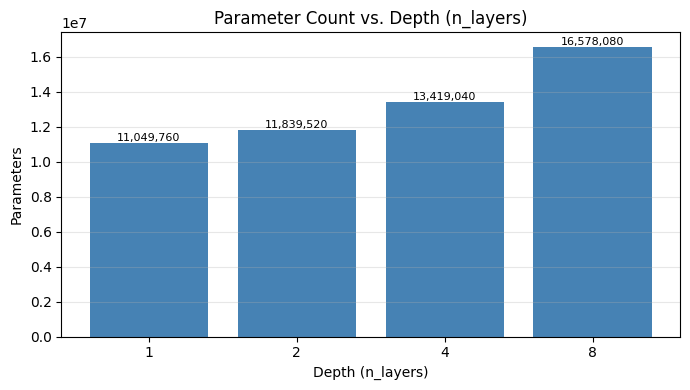

Saved /content/experiment_outputs_wikitext2/depth_param_count.png


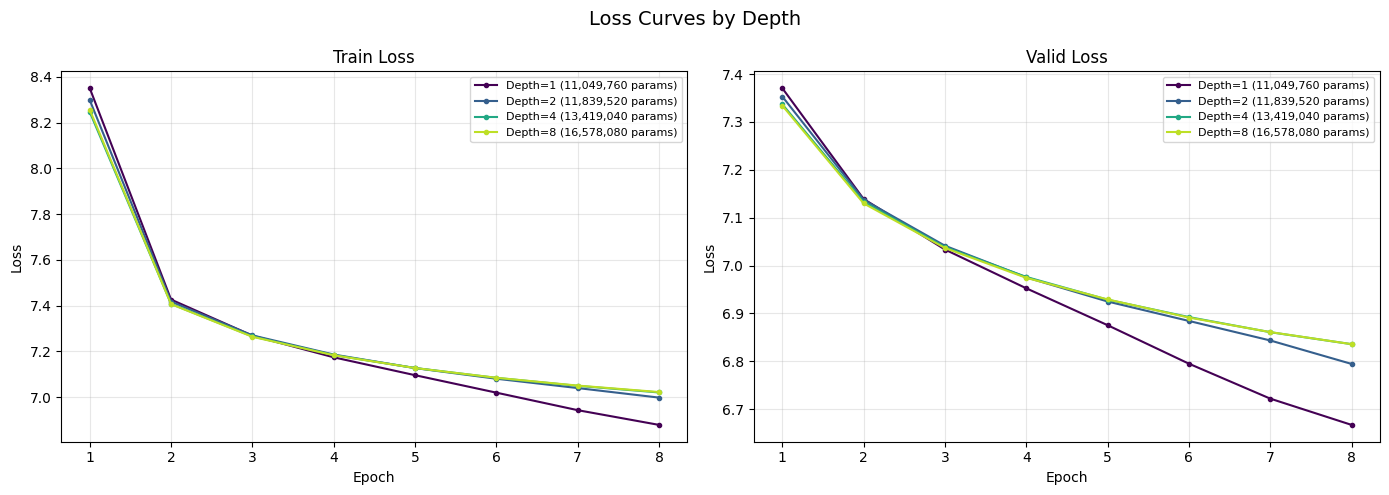

Saved /content/experiment_outputs_wikitext2/depth_loss_curves.png


In [15]:
depth_results = run_sweep(CONFIG['depths'], CONFIG, vary='depth')

save_results(depth_results, os.path.join(OUTPUT_DIR, 'depth_results.json'))


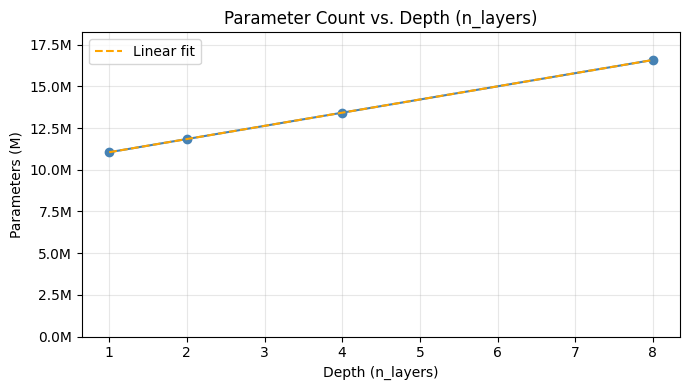

Saved /content/experiment_outputs_wikitext2/depth_param_count.png


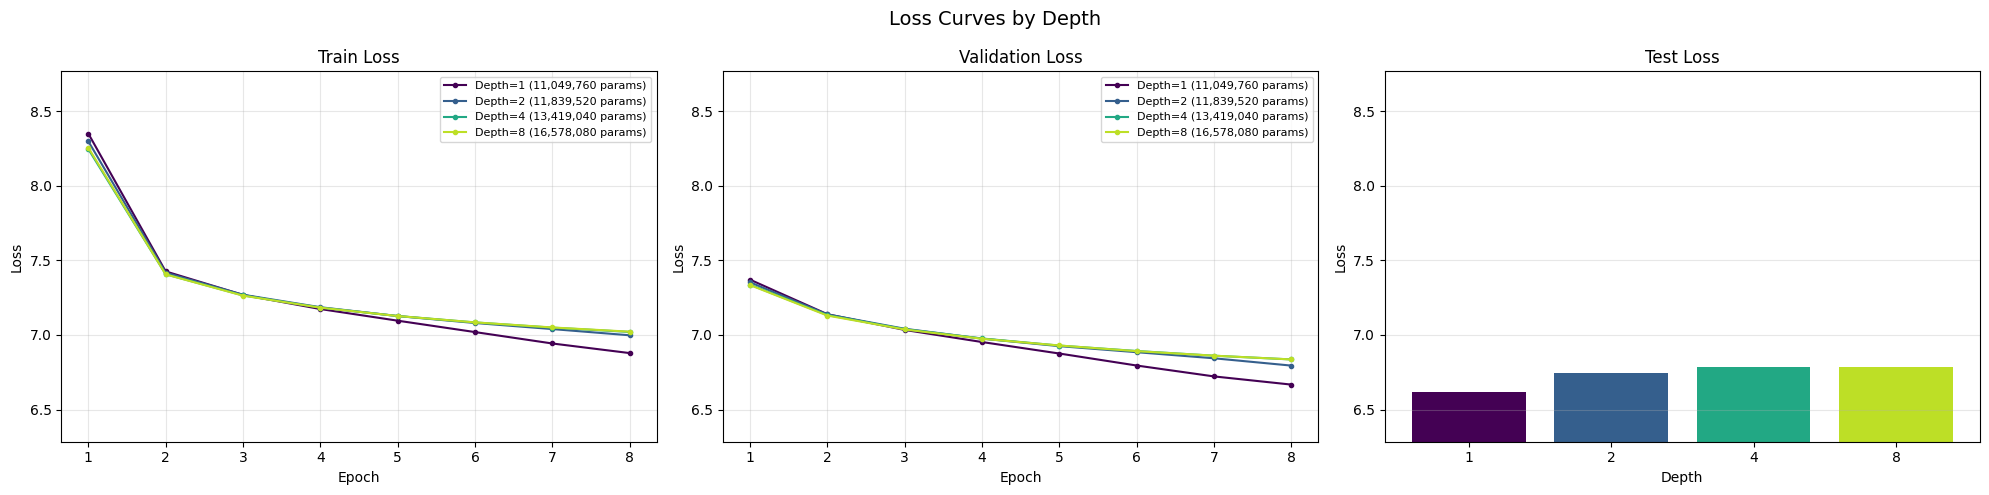

Saved /content/experiment_outputs_wikitext2/depth_loss_curves.png


In [43]:
plot_param_count(depth_results, 'Depth (n_layers)',
                 os.path.join(OUTPUT_DIR, 'depth_param_count.png'))
plot_loss_curves(depth_results, 'Depth',
                 os.path.join(OUTPUT_DIR, 'depth_loss_curves.png'))

## 8. Width Experiment (vary d_model, fixed n_layers)

In [44]:
width_results = run_sweep(CONFIG['widths'], CONFIG, vary='width')

save_results(width_results, os.path.join(OUTPUT_DIR, 'width_results.json'))

Device: cuda  |  Sweeping width over [64, 128, 256, 512]

Training width=64
  d_model=64  n_layers=4  d_ff=256  params=2,779,936
  Epoch  1/8 | train loss 8.8949 | valid loss 7.8069 | valid ppl 2457.40 | time 9.8s
  Epoch  2/8 | train loss 7.7411 | valid loss 7.3344 | valid ppl 1532.15 | time 9.9s
  Epoch  3/8 | train loss 7.4270 | valid loss 7.1549 | valid ppl 1280.37 | time 10.1s
  Epoch  4/8 | train loss 7.2843 | valid loss 7.0469 | valid ppl 1149.32 | time 10.3s
  Epoch  5/8 | train loss 7.1840 | valid loss 6.9642 | valid ppl 1058.11 | time 10.4s
  Epoch  6/8 | train loss 7.1084 | valid loss 6.9013 | valid ppl 993.60 | time 10.7s
  Epoch  7/8 | train loss 7.0502 | valid loss 6.8504 | valid ppl 944.23 | time 10.8s
  Epoch  8/8 | train loss 7.0046 | valid loss 6.8127 | valid ppl 909.33 | time 10.7s
  Test loss 6.7613 | ppl 863.80 | acc 5.74%

Training width=128
  d_model=128  n_layers=4  d_ff=512  params=5,933,088
  Epoch  1/8 | train loss 8.5288 | valid loss 7.5398 | valid ppl 1881.

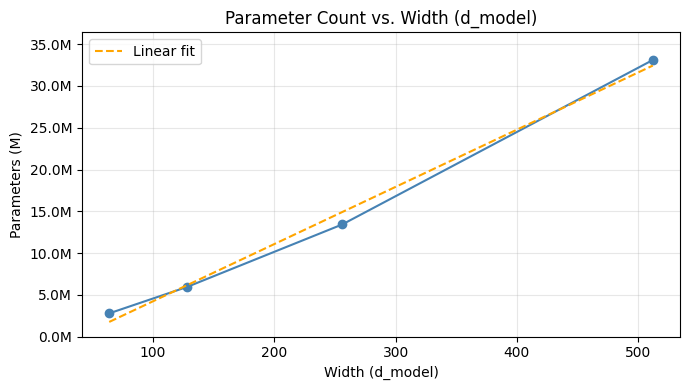

Saved /content/experiment_outputs_wikitext2/width_param_count.png


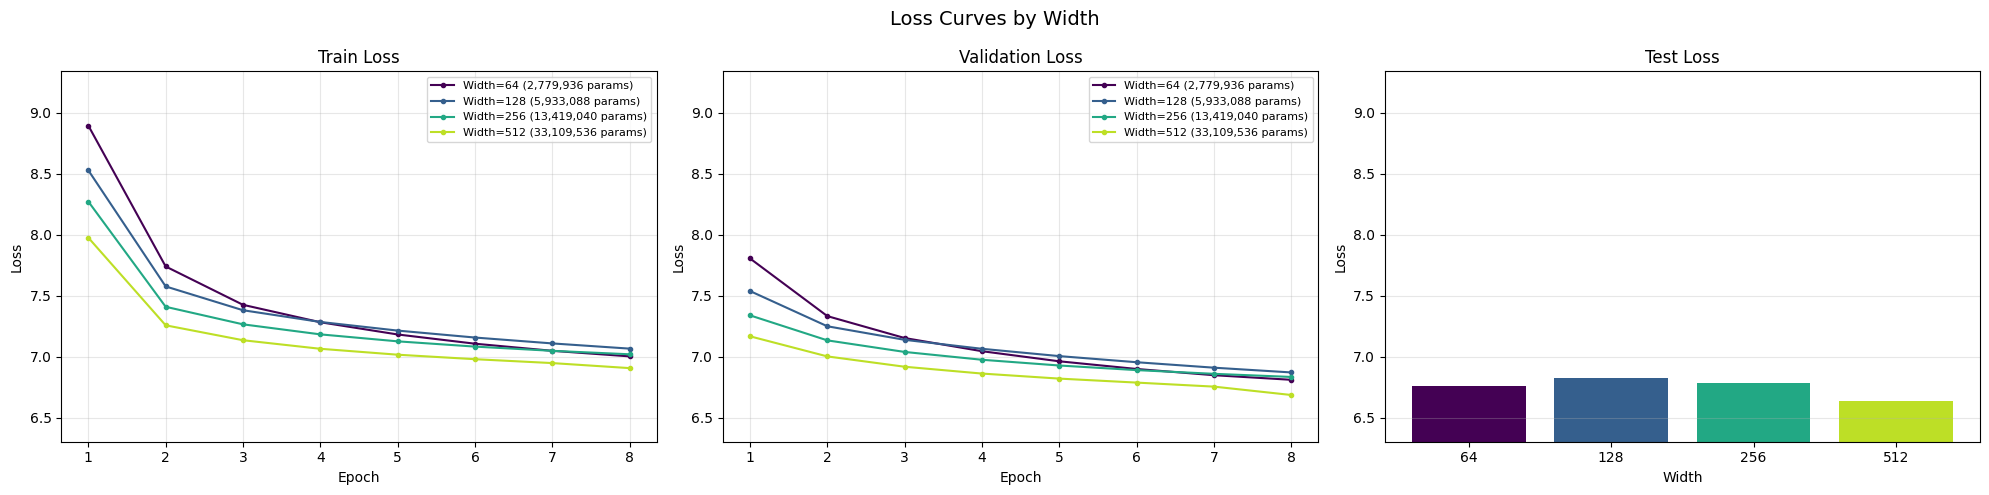

Saved /content/experiment_outputs_wikitext2/width_loss_curves.png


In [45]:
plot_param_count(width_results, 'Width (d_model)',
                 os.path.join(OUTPUT_DIR, 'width_param_count.png'))
plot_loss_curves(width_results, 'Width',
                 os.path.join(OUTPUT_DIR, 'width_loss_curves.png'))

## 9. Batch Size Sweep

In [ ]:
def build_batch_size_model(val, config):
    model = TransformerDecoder(
        vocab_size=len(itos),
        d_model=config['reg_d_model'],
        n_heads=config['n_heads'],
        n_layers=config['reg_n_layers'],
        d_ff=config['reg_d_ff'],
        dropout=config['dropout'],
        max_len=config['max_len'],
    )
    optimizer = optim.SGD(model.parameters(), lr=config['lr'],
                          momentum=config['momentum'],
                          weight_decay=config['weight_decay'])
    return model, optimizer, 0.0

def make_batch_loader(batch_size):
    return DataLoader(TensorDataset(train_x, train_y),
                      batch_size=batch_size, shuffle=True)

batch_results = run_regularization_sweep(
    'BatchSize', CONFIG['batch_sizes'], build_batch_size_model, CONFIG,
    make_loader_fn=make_batch_loader,
)

save_results(batch_results, os.path.join(OUTPUT_DIR, 'batch_size_results.json'))
plot_loss_curves(batch_results, 'BatchSize',
                 os.path.join(OUTPUT_DIR, 'batch_size_loss_curves.png'))

## 10. Dropout Sweep

In [ ]:
def build_dropout_model(val, config):
    model = TransformerDecoder(
        vocab_size=len(itos),
        d_model=config['reg_d_model'],
        n_heads=config['n_heads'],
        n_layers=config['reg_n_layers'],
        d_ff=config['reg_d_ff'],
        dropout=val,
        max_len=config['max_len'],
    )
    optimizer = optim.SGD(model.parameters(), lr=config['lr'],
                          momentum=config['momentum'],
                          weight_decay=config['weight_decay'])
    return model, optimizer, 0.0

dropout_results = run_regularization_sweep(
    'Dropout', CONFIG['dropout_rates'], build_dropout_model, CONFIG,
)

save_results(dropout_results, os.path.join(OUTPUT_DIR, 'dropout_results.json'))
plot_loss_curves(dropout_results, 'Dropout',
                 os.path.join(OUTPUT_DIR, 'dropout_loss_curves.png'))

## 11. L2 Regularization Sweep (weight decay)

In [ ]:
def build_l2_model(val, config):
    model = TransformerDecoder(
        vocab_size=len(itos),
        d_model=config['reg_d_model'],
        n_heads=config['n_heads'],
        n_layers=config['reg_n_layers'],
        d_ff=config['reg_d_ff'],
        dropout=config['dropout'],
        max_len=config['max_len'],
    )
    optimizer = optim.SGD(model.parameters(), lr=config['lr'],
                          momentum=config['momentum'],
                          weight_decay=val)
    return model, optimizer, 0.0

l2_results = run_regularization_sweep(
    'L2 (weight_decay)', CONFIG['l2_weights'], build_l2_model, CONFIG,
)

save_results(l2_results, os.path.join(OUTPUT_DIR, 'l2_results.json'))
plot_loss_curves(l2_results, 'L2 (weight_decay)',
                 os.path.join(OUTPUT_DIR, 'l2_loss_curves.png'))

## 12. L1 Sweep

In [ ]:
def build_l1_model(val, config):
    model = TransformerDecoder(
        vocab_size=len(itos),
        d_model=config['reg_d_model'],
        n_heads=config['n_heads'],
        n_layers=config['reg_n_layers'],
        d_ff=config['reg_d_ff'],
        dropout=config['dropout'],
        max_len=config['max_len'],
    )
    optimizer = optim.SGD(model.parameters(), lr=config['lr'],
                          momentum=config['momentum'],
                          weight_decay=config['weight_decay'])
    return model, optimizer, val

l1_results = run_regularization_sweep(
    'L1', CONFIG['l1_weights'], build_l1_model, CONFIG,
)

save_results(l1_results, os.path.join(OUTPUT_DIR, 'l1_results.json'))
plot_loss_curves(l1_results, 'L1',
                 os.path.join(OUTPUT_DIR, 'l1_loss_curves.png'))

## 13. Elastic Net -- Ratio Sweep

Fixed total strength, sweep the L1/L2 ratio (0 = pure L2, 1 = pure L1).

In [ ]:
def build_enet_ratio_model(ratio, config):
    total = config['enet_total_strength']
    l1_lam = total * ratio
    wd = total * (1 - ratio)
    model = TransformerDecoder(
        vocab_size=len(itos),
        d_model=config['reg_d_model'],
        n_heads=config['n_heads'],
        n_layers=config['reg_n_layers'],
        d_ff=config['reg_d_ff'],
        dropout=config['dropout'],
        max_len=config['max_len'],
    )
    optimizer = optim.SGD(model.parameters(), lr=config['lr'],
                          momentum=config['momentum'],
                          weight_decay=wd)
    return model, optimizer, l1_lam

enet_ratio_results = run_regularization_sweep(
    'ENet Ratio', CONFIG['enet_ratios'], build_enet_ratio_model, CONFIG,
)

save_results(enet_ratio_results, os.path.join(OUTPUT_DIR, 'enet_ratio_results.json'))
plot_loss_curves(enet_ratio_results, 'ENet Ratio',
                 os.path.join(OUTPUT_DIR, 'enet_ratio_loss_curves.png'))

## 14. Elastic Net -- Strength Sweep

Fixed L1/L2 ratio, sweep the total regularization strength.

In [ ]:
def build_enet_strength_model(strength, config):
    ratio = config['enet_ratio']
    l1_lam = strength * ratio
    wd = strength * (1 - ratio)
    model = TransformerDecoder(
        vocab_size=len(itos),
        d_model=config['reg_d_model'],
        n_heads=config['n_heads'],
        n_layers=config['reg_n_layers'],
        d_ff=config['reg_d_ff'],
        dropout=config['dropout'],
        max_len=config['max_len'],
    )
    optimizer = optim.SGD(model.parameters(), lr=config['lr'],
                          momentum=config['momentum'],
                          weight_decay=wd)
    return model, optimizer, l1_lam

enet_strength_results = run_regularization_sweep(
    'ENet Strength', CONFIG['enet_strengths'], build_enet_strength_model, CONFIG,
)

save_results(enet_strength_results, os.path.join(OUTPUT_DIR, 'enet_strength_results.json'))
plot_loss_curves(enet_strength_results, 'ENet Strength',
                 os.path.join(OUTPUT_DIR, 'enet_strength_loss_curves.png'))

## 15. Summary

In [ ]:
print('=' * 60)
print('ALL EXPERIMENTS COMPLETE')
print('=' * 60)
print('\nOutput directory:', OUTPUT_DIR)
print('\nGenerated files:')
for f in sorted(os.listdir(OUTPUT_DIR)):
    path = os.path.join(OUTPUT_DIR, f)
    if os.path.isfile(path):
        size_kb = os.path.getsize(path) / 1024
        print(f'  {f} ({size_kb:.1f} KB)')